In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Clone the repository
!git clone https://github.com/LoreJob/DeepFake-Dct.git

Cloning into 'DeepFake-Dct'...
remote: Enumerating objects: 173389, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 173389 (delta 58), reused 173 (delta 56), pack-reused 173214
Receiving objects: 100% (173389/173389), 1.72 GiB | 30.16 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Updating files: 100% (380680/380680), done.


In [13]:
image_dimensions = {'height': 256, 'width': 256, 'channels': 3}

class Classifier:
    def __init__(self):
        self.model = 0

    def predict(self, x):
        return self.model.predict(x)

    def fit(self, x, y):
        return self.model.train_on_batch(x, y)

    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)

    def load(self, path):
        self.model.load_weights(path)

class Meso4(Classifier):
    def __init__(self, learning_rate=0.001):
        self.model = self.init_model()
        optimizer = Adam(lr=learning_rate)
        self.model.compile(optimizer=optimizer,
                           loss='mean_squared_error',
                           metrics=['accuracy'])

    def init_model(self):
        x = Input(shape=(image_dimensions['height'],
                         image_dimensions['width'],
                         image_dimensions['channels']))

        x1 = Conv2D(8, (3, 3), padding='same', activation='relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)

        x2 = Conv2D(8, (5, 5), padding='same', activation='relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)

        x3 = Conv2D(16, (5, 5), padding='same', activation='relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)

        x4 = Conv2D(16, (5, 5), padding='same', activation='relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)

        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation='sigmoid')(y)

        return Model(inputs=x, outputs=y)

meso = Meso4()

dataGenerator = ImageDataGenerator(rescale=1./255)

train_generator = dataGenerator.flow_from_directory(
    '/content/DeepFake-Dct/dataset big/Train',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    subset='training')


Found 140002 images belonging to 2 classes.


In [33]:
dataGenerator = ImageDataGenerator(rescale=1./255, validation_split=0.9999999999)

validation_generator = dataGenerator.flow_from_directory(
    '/content/DeepFake-Dct/dataset big/Validation',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    subset='validation')

print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {validation_generator.samples}")

Found 39426 images belonging to 2 classes.
Number of training samples: 140002
Number of validation samples: 39426


In [ ]:
# Train the model
history = meso.model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator)

meso.model.save('meso4_model.h5')

Epoch 1/10
4376/4376 [==============================] - 349s 80ms/step - loss: 0.0881 - accuracy: 0.8816 - val_loss: 0.0916 - val_accuracy: 0.8744
Epoch 2/10
4376/4376 [==============================] - 336s 77ms/step - loss: 0.0569 - accuracy: 0.9243 - val_loss: 0.0652 - val_accuracy: 0.9110
Epoch 3/10
4376/4376 [==============================] - 324s 74ms/step - loss: 0.0477 - accuracy: 0.9363 - val_loss: 0.0650 - val_accuracy: 0.9145
Epoch 4/10
4376/4376 [==============================] - 344s 79ms/step - loss: 0.0437 - accuracy: 0.9425 - val_loss: 0.0591 - val_accuracy: 0.9198
Epoch 5/10
4376/4376 [==============================] - 337s 77ms/step - loss: 0.0403 - accuracy: 0.9465 - val_loss: 0.0536 - val_accuracy: 0.9274
Epoch 6/10
4376/4376 [==============================] - 331s 76ms/step - loss: 0.0375 - accuracy: 0.9500 - val_loss: 0.0535 - val_accuracy: 0.9274
Epoch 7/10
4376/4376 [==============================] - 314s 72ms/step - loss: 0.0358 - accuracy: 0.9529 - val_loss: 0

In [16]:
test_data_generator = ImageDataGenerator(rescale=1./255)

test_generator = test_data_generator.flow_from_directory(
    '/content/DeepFake-Dct/dataset big/Test',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

test_loss, test_accuracy = meso.model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

test_predictions = meso.model.predict(test_generator)

Found 10905 images belonging to 2 classes.
341/341 [==============================] - 20s 59ms/step - loss: 0.0822 - accuracy: 0.8901
Test Loss: 0.08223803341388702
Test Accuracy: 0.8901421427726746
341/341 [==============================] - 21s 60ms/step


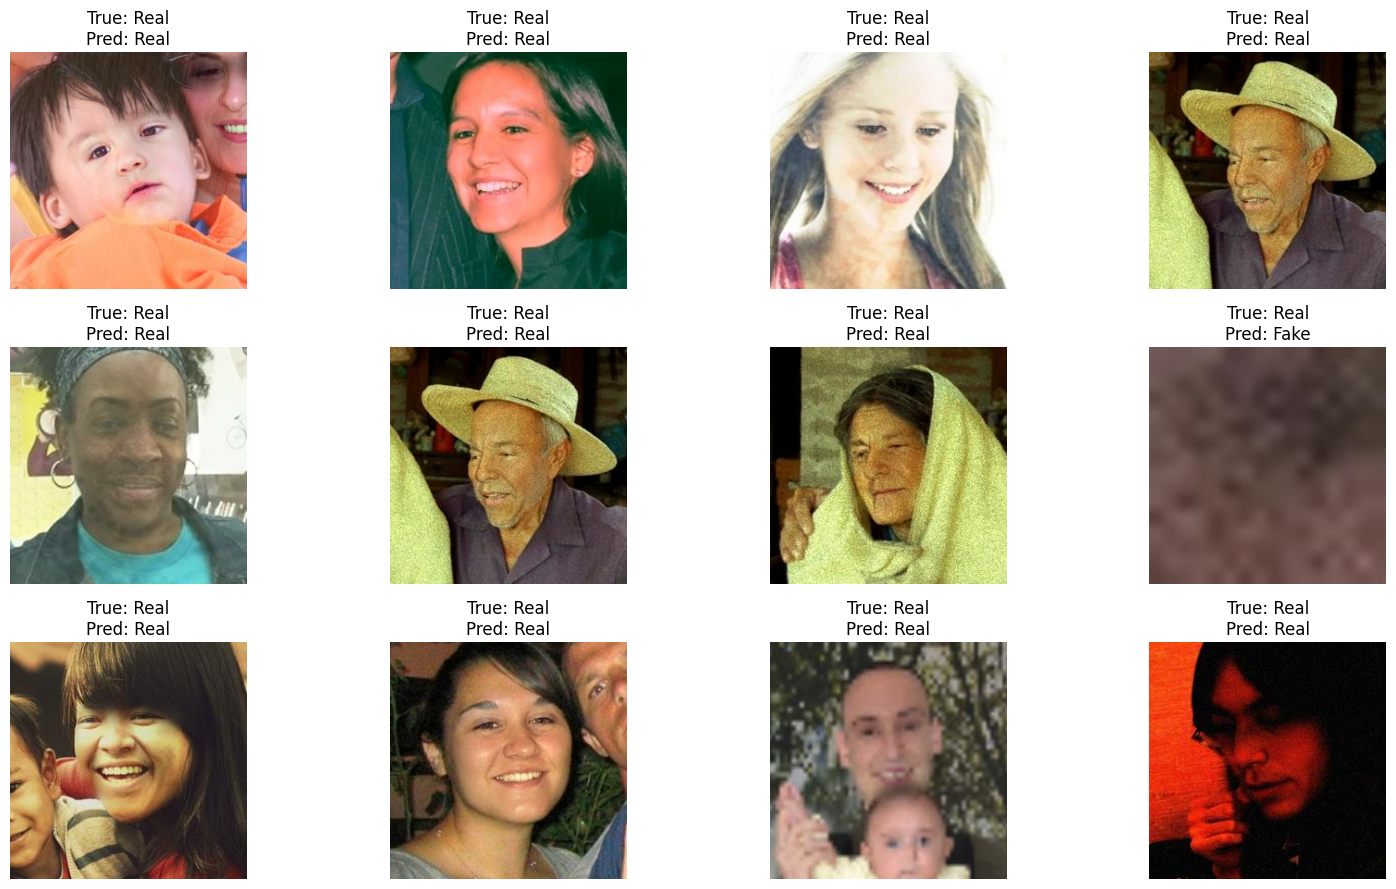

In [17]:
def plot_predictions(images, labels, predictions, class_indices):
    fig = plt.figure(figsize=(16, 9))
    subset = np.random.randint(0, len(images)-1, 12)
    for i, idx in enumerate(subset):
        ax = fig.add_subplot(3, 4, i + 1)
        ax.imshow(images[idx])
        pred_label = 'Fake' if predictions[idx] > 0.5 else 'Real'
        true_label = 'Fake' if labels[idx] > 0.5 else 'Real'
        ax.set_title(f"True: {true_label}\nPred: {pred_label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

test_images, test_labels = next(test_generator)
plot_predictions(test_images, test_labels, test_predictions[:64], test_generator.class_indices)